In [1]:
## Notebook for extracting pupil data etc

In [1]:
%load_ext autoreload
%autoreload 2

In [19]:
# general imports
import sys
import pickle
import os
import json
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
# import seaborn as sns
import copy

# from scipy import stats
# from scipy.optimize import curve_fit
# from statsmodels.stats import multitest
# from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)

import popoff
import pop_off_functions as pof
import pop_off_plotting as pop

from Session import Session, SessionLite, build_flu_array_single


In [4]:
# ## put your path to your vape repo here 
# path_to_vape = os.path.expanduser('~/Documents/code/Vape/')
# popoff_path = '/home/jrowland/Documents/code/pop-off/scripts/'

# # Bit hacky but oh well
# sys.path.append(path_to_vape)
# sys.path.append(os.path.join(path_to_vape, 'utils'))
# sys.path.append(popoff_path)

# from utils.utils_funcs import d_prime

In [10]:
df_pupil_mice = pd.DataFrame({'mouse': ['RL117', 'RL117'], 'run_number': [29, 30],
                              'filename_prefix': ['2021-03-09_RL117', '2021-03-10_RL117']})
df_pupil_mice['signature'] = df_pupil_mice['mouse'] + '_' + df_pupil_mice['run_number'].astype(str)
df_pupil_mice

,mouse,run_number,filename_prefix,signature
0,RL117,29,2021-03-09_RL117,RL117_29
1,RL117,30,2021-03-10_RL117,RL117_30


In [34]:
def load_pupil_data(df_pupil_mice, dir='/home/tplas/data/mice'):
    dict_pupil_data = {signature: {} for signature in df_pupil_mice['signature']}

    for i_sess, signature in enumerate(dict_pupil_data.keys()):
        basic_filename = os.path.join(dir, df_pupil_mice[df_pupil_mice['signature'] == signature]['filename_prefix'].iloc[0])
        dict_pupil_data[signature]['area_array'] = np.load(basic_filename + '_AreaArray.npy')
        dict_pupil_data[signature]['binary_score'] = np.load(basic_filename + '_BinaryScore.npy')
        dict_pupil_data[signature]['r2_distance'] = np.load(basic_filename + '_r2Distance.npy')

    handle_outliers()

    return dict_pupil_data

def handle_outliers():
    print('WARNING: outliers not yet processed')
    pass
    

dict_pupil_data = load_pupil_data(df_pupil_mice=df_pupil_mice)

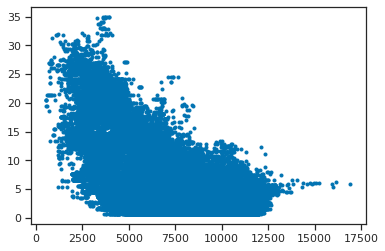

In [35]:
plt.plot(dict_pupil_data['RL117_29']['area_array'], dict_pupil_data['RL117_29']['r2_distance'], '.')

In [36]:
## Load run 
def load_run(mouse, run_number, base_path):
    pkl_path = os.path.join(base_path, mouse, f'run{run_number}.pkl')
    print(pkl_path)
    with open(pkl_path, 'rb') as f:
        run = pickle.load(f)
    
    return run

def get_dict_runs(df_pupil_mice):

    dict_runs = {} 
    for i_sess in range(len(df_pupil_mice)):
        print(df_pupil_mice['signature'].iloc[i_sess])
        dict_runs[df_pupil_mice['signature'].iloc[i_sess]] = load_run(mouse=df_pupil_mice['mouse'].iloc[i_sess],
                                                                      run_number=df_pupil_mice['run_number'].iloc[i_sess],
                                                                      base_path='/home/tplas/data/mice/runs/')
    return dict_runs

dict_runs = get_dict_runs(df_pupil_mice=df_pupil_mice)

RL117_29
/home/tplas/data/mice/runs/RL117/run29.pkl
RL117_30
/home/tplas/data/mice/runs/RL117/run30.pkl


In [37]:
dict_runs['RL117_29'].flu.shape

(507, 130411)

In [38]:
dict_pupil_data['RL117_29']['area_array'].shape

(144512,)

In [39]:
def filter_frames_first_pass(run, pupil):
    idx_imaged = np.isin(run.frame_clock, run.paqio_frames)
    assert sum(idx_imaged) == run.flu.shape[1]
    assert len(idx_imaged) == len(pupil)
    pupil = pupil[idx_imaged]
    return pupil

for signature in dict_pupil_data.keys():
    for name_p in ['area_array', 'r2_distance']:
        dict_pupil_data[signature][name_p] = filter_frames_first_pass(run=dict_runs[signature], 
                                                                      pupil=dict_pupil_data[signature][name_p])

In [57]:
## I am James Rowland and this is my invention:

for signature in df_pupil_mice['signature']:
    
    dict_runs[signature].pupil = np.expand_dims(dict_pupil_data[signature]['area_array'], 0)  # add to run so we can use build_flu_array_single 
    dict_pupil_data[signature]['pupil_size'] = np.squeeze(build_flu_array_single(run=dict_runs[signature], use_pupil=True, 
                                                                      pre_frames=120, post_frames=180))  # use session pre_frames & post_frames here

    ## filter non nan trails
    

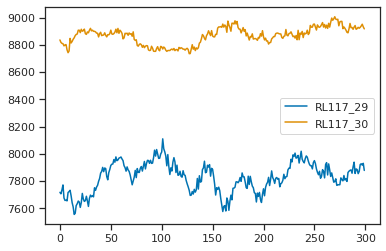

In [58]:
for signature in ['RL117_29', 'RL117_30']:
    # print(dict_pupil_data[signature]['pupil_size'].shape)

    plt.plot(np.nanmean(dict_pupil_data[signature]['pupil_size'], 0), label=signature )

plt.legend()

## Analysis to do:
- Show dynamics of pupil size on hit vs miss trials (validation that it worked)
- Show histogram of pre-stim pupil size hit vs miss
- Scatter plot pupil size vs pop var (both just pre-stim & full dynamics)
- Optionally, as control, compare pupil size pre-stim vs n_stim 